# Predicción de la satisfacción del cliente

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
order = pd.read_csv('./../limpio/olist_orders_dataset.csv', delimiter=';')
item = pd.read_csv('./../limpio/olist_order_items_dataset.csv', delimiter=';')
review = pd.read_csv('./../limpio/olist_order_reviews_dataset.csv', delimiter=';')
product = pd.read_csv('./../limpio/olist_products_dataset.csv', delimiter=';')
payment = pd.read_csv('./../limpio/olist_order_payments_dataset.csv', delimiter=';')
customer = pd.read_csv('./../limpio/olist_customers_dataset.csv', delimiter=';')
geolocation = pd.read_csv('./../limpio/olist_geolocation_dataset.csv', delimiter=';')
seller = pd.read_csv('./../limpio/olist_sellers_dataset.csv', delimiter=';')
geolocation = pd.read_csv('./../limpio/olist_geolocation_dataset.csv', delimiter=';')

# Objetivo

**"¿Cuál es la puntuación probable que obtenemos de los clientes? "**.

Buscamos estimar, basándose en los datos sobre el producto y el pedido, cuál será la puntuación de los clientes.

# Hipótesis
Nuestra hipótesis principal es que el producto y la forma en que se ha realizado el pedido y la entrega pueden influir en la puntuación de las reseñas de los clientes.

# Procedimiento

Para responder a la pregunta debemos cargar los datos de cada pedido hasta la fase de entrega. Con eso, debemos implementar un modelo que estime cuál será la puntuación dada por el cliente en la fase de revisión.

In [3]:
# Vamos a cargar todos los datos en una sola tabla grande

order_items_products = pd.merge(item,product,on='product_id')
order_items_products_sellers = pd.merge(order_items_products,seller,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,order,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,customer,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,review,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,payment,on='order_id')

In [4]:
# Convertimos los datos de fechas

final_dataframe['order_purchase_timestamp'] = pd.to_datetime(final_dataframe.order_purchase_timestamp)   
final_dataframe['order_approved_at'] = pd.to_datetime(final_dataframe.order_approved_at).dt.date  
final_dataframe['order_estimated_delivery_date'] = pd.to_datetime(final_dataframe.order_estimated_delivery_date).dt.date  
final_dataframe['order_delivered_customer_date'] = pd.to_datetime(final_dataframe.order_delivered_customer_date).dt.date

In [5]:
final_dataframe.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,espanol,product_name_lenght,...,customer_zip_code_prefix,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,Cool stuff,Cosas interesantes,58.0,...,28013,97ca439bc427b48bc1cd7177abe71365,5,Sin Dato,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,Cool stuff,Cosas interesantes,58.0,...,75800,b11cba360bbe71410c291b764753d37f,5,Sin Dato,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,Cool stuff,Cosas interesantes,58.0,...,30720,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,credit_card,2,83.23
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,Cool stuff,Cosas interesantes,58.0,...,83070,8304ff37d8b16b57086fa283fe0c44f8,5,Sin Dato,Sin Dato,2017-08-10 00:00:00,2017-08-13 03:35:17,credit_card,3,75.07
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,Cool stuff,Cosas interesantes,58.0,...,36400,426f43a82185969503fb3c86241a9535,5,Sin Dato,Sin Dato,2017-08-25 00:00:00,2017-08-28 00:51:18,credit_card,4,72.19


In [6]:
final_dataframe.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'espanol', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

Vamos a tomar solo las columnas que creemos convenientes

In [7]:
final_dataframe = final_dataframe[['freight_value', 'espanol', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date',
       'order_estimated_delivery_date',
       'review_score']]

In [8]:
final_dataframe.head()

,freight_value,espanol,product_name_lenght,product_description_lenght,product_photos_qty,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,13.29,Cosas interesantes,58.0,598.0,4.0,delivered,2017-09-13 08:59:02,2017-09-13,2017-09-20,2017-09-29,5
1,17.96,Cosas interesantes,58.0,598.0,4.0,delivered,2017-06-28 11:52:20,2017-06-29,2017-07-13,2017-07-26,5
2,18.33,Cosas interesantes,58.0,598.0,4.0,delivered,2018-05-18 10:25:53,2018-05-18,2018-06-04,2018-06-07,4
3,16.17,Cosas interesantes,58.0,598.0,4.0,delivered,2017-08-01 18:38:42,2017-08-01,2017-08-09,2017-08-25,5
4,13.29,Cosas interesantes,58.0,598.0,4.0,delivered,2017-08-10 21:48:40,2017-08-10,2017-08-24,2017-09-01,5


In [9]:
final_dataframe.isna().sum()

freight_value                       0
espanol                             0
product_name_lenght              1628
product_description_lenght       1628
product_photos_qty               1628
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_customer_date    2396
order_estimated_delivery_date       0
review_score                        0
dtype: int64

In [10]:
# Hay valoores faltantes, vamos a eliminarlos
final_dataframe=final_dataframe.dropna()
final_dataframe = final_dataframe.reset_index().drop(['index'],axis=1)

### División del conjunto de datos
Vamos a dividir nuestros datos ahora para evitar introducir algún sesgo no deseado. 

> Para dividir correctamente, veamos primero cómo se distribuyen las clases en el conjunto de datos completo.

In [11]:
final_dataframe['review_score'].value_counts() / len(final_dataframe['review_score'])

5    0.574489
4    0.193666
1    0.113607
3    0.084379
2    0.033860
Name: review_score, dtype: float64

#### División simple
Probemos primero una división aleatoria simple y veamos si las proporciones se mantienen iguales.

In [12]:
from sklearn.model_selection import train_test_split

# split
train_set, test_set = train_test_split(final_dataframe, test_size=0.2, random_state=42)

In [13]:
test_set['review_score'].value_counts() / len(test_set['review_score'])

5    0.576548
4    0.194654
1    0.111447
3    0.084169
2    0.033182
Name: review_score, dtype: float64

Vemos que hay cierta diferencia entre la proporción de cada clase en comparación con el conjunto de datos original.

#### División estratificada
Ahora vamos a hacer una división estratificada y comparar con el conjunto de datos completo de nuevo.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(final_dataframe, final_dataframe['review_score']):
    strat_train_set = final_dataframe.loc[train_index]
    strat_test_set = final_dataframe.loc[test_index]

In [15]:
strat_train_set['review_score'].value_counts() / len(strat_train_set['review_score'])

5    0.574489
4    0.193670
1    0.113609
3    0.084375
2    0.033857
Name: review_score, dtype: float64

Al hacer una división estratificada, mantenemos la misma proporción entre las clases. Esta división representa mejor los datos originales y posiblemente reducirá cualquier sesgo.

### Separación de las puntuaciones y las características
No queremos aplicar ninguna transformación a las puntuaciones (review_score). Para evitarlo, simplemente creamos una serie separada con las puntuaciones, y eliminamos esa columna del conjunto de datos de las características.

In [16]:
orders_features = strat_train_set.drop('review_score', axis=1)
orders_labels = strat_train_set['review_score'].copy()

## Ingeniería de características
Veamos la correlación entre las columnas

In [17]:
corr_matrix = strat_train_set.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.018103
product_description_lenght    0.015066
product_name_lenght          -0.016363
freight_value                -0.034275
Name: review_score, dtype: float64

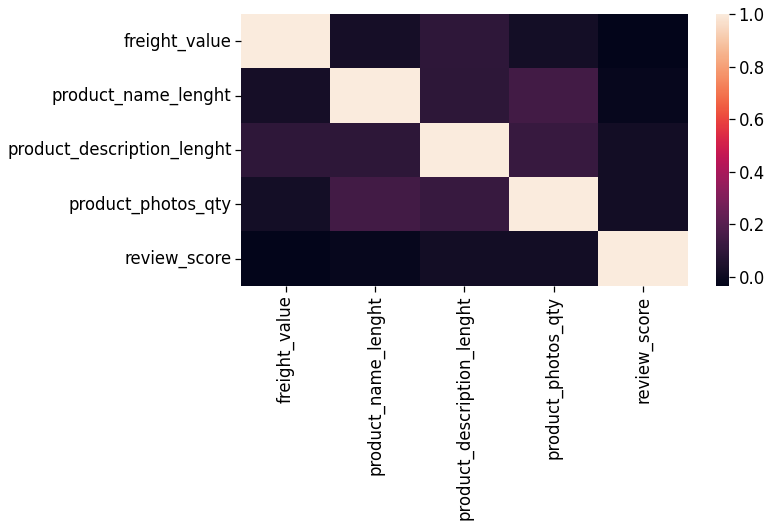

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix)
plt.show()

Notamos que no hay muchas columnas que estén correlacionadas con el objetivo en los datos originales.

Vamos a crear características más informativas para modelar este problema.

### Características Hipotesis

#### Tiempo estimado de entrega en días
Obtiene los días entre la aprobación del pedido y la fecha estimada de entrega. Un cliente puede estar insatisfecho si se le dice que el tiempo estimado es grande.

#### Tiempo de entrega real en días
Obtiene los días entre la aprobación del pedido y la fecha de entrega al cliente. Un cliente puede estar más satisfecho si recibe el producto más rápido.

#### Tiempo de entrega Delta en días
La diferencia entre la fecha real y la estimada.  Si es negativa se entregó antes, si es positiva se entregó tarde. Un cliente podría estar más satisfecho si el pedido llega antes de lo previsto, o descontento si lo recibe después de la fecha límite

#### Retraso en el tiempo de entrega
Variable binaria que indica si el pedido fue entregado después de la fecha estimada.

#### Día de la semana de la compra
¿Afecta a la satisfacción de los clientes?

### Creación de un transformador personalizado para FeatEng
Necesitamos garantizar que estamos aplicando exactamente la misma transformación a los datos nuevos/no vistos. Para ello vamos a crear transformadores personalizados utilizando scikit-learn BaseEstimator.

Este primer transformador personalizado hará la ingeniería de características que acabamos de describir anteriormente.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # Calcular el plazo de entrega estimado y el plazo de entrega real en cantidad de días. 
        # Si la fecha de entrega del cliente es nula, devuelve 0.
        
        df['wd_estimated_delivery_time'] = df.order_estimated_delivery_date - df.order_approved_at

        df['wd_actual_delivery_time'] = df.order_delivered_customer_date - df.order_approved_at 
                                                                                   

        # Calcula el tiempo entre la fecha de entrega real y la estimada.
        # Si es negativo se entregó antes, si es positivo se entregó tarde.
        df['wd_delivery_time_delta'] = df.wd_actual_delivery_time - df.wd_estimated_delivery_time

        # Calcula el tiempo entre la fecha de entrega real y la estimada. Si el negativo se entregó antes, si el positivo se entregó tarde.
        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        # Calcula el ratio de carga de los pedidos.
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
                       
        # Con esto podemos eliminar las marcas de tiempo del conjunto de datos
        cols2drop = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        # Convertimos los dìas estimados en valores numèricos
        df['wd_estimated_delivery_time'] = pd.to_numeric(df.wd_estimated_delivery_time/np.timedelta64(1, 'D'))
        df['wd_actual_delivery_time'] = pd.to_numeric(df.wd_actual_delivery_time/np.timedelta64(1, 'D'))
        df['wd_delivery_time_delta'] = pd.to_numeric(df.wd_delivery_time_delta/np.timedelta64(1, 'D'))

        return df

Aplicamos las nuevas características

In [20]:
# Ejecución del estimador que acabamos de crear
attr_adder = AttributesAdder()

In [21]:

feat_eng = attr_adder.transform(strat_train_set)

In [22]:
feat_eng.head()

,freight_value,espanol,product_name_lenght,product_description_lenght,product_photos_qty,order_status,review_score,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,purchase_dayofweek
7708,16.11,Cosas interesantes,41.0,578.0,2.0,delivered,3,26.0,18.0,-8.0,False,4
53329,9.60,Decoración de muebles,26.0,669.0,4.0,delivered,5,11.0,2.0,-9.0,False,0
7742,15.10,Juguetes,57.0,571.0,1.0,delivered,5,22.0,9.0,-13.0,False,5
77631,15.23,Electrodomésticos,59.0,709.0,2.0,delivered,5,35.0,13.0,-22.0,False,2
92434,15.10,Ocio deportivo,52.0,305.0,1.0,delivered,5,29.0,8.0,-21.0,False,3


### Correlación
Veamos la correlación de las características que acabamos de crear con la puntuación de la review

In [23]:
corr_matrix = feat_eng.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.018103
product_description_lenght    0.015066
purchase_dayofweek           -0.012253
product_name_lenght          -0.016363
freight_value                -0.034275
wd_estimated_delivery_time   -0.059254
wd_delivery_time_delta       -0.230517
wd_actual_delivery_time      -0.304019
is_late                      -0.357496
Name: review_score, dtype: float64

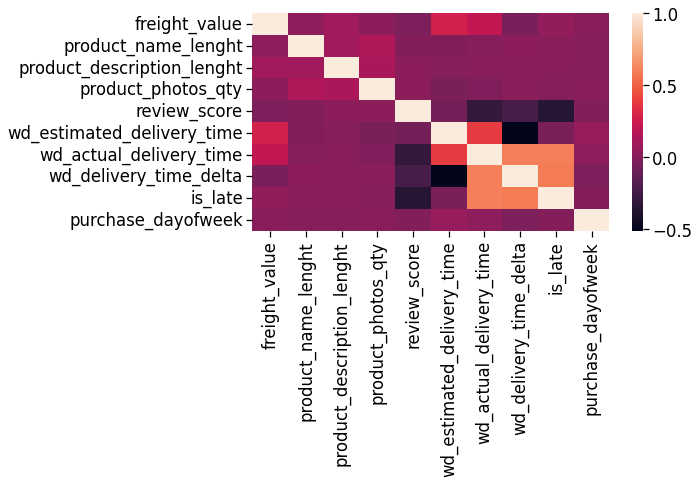

In [24]:
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix)
plt.show()

Parece que está bien, no hay ninguna correlación fuerte. Pero está claro que si un cliente da una puntuación más baja si recibe un pedido después de la fecha estimada. 

Veamos si hay algún valor faltante.

In [25]:
feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87396 entries, 7708 to 936
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   freight_value               87396 non-null  float64
 1   espanol                     87396 non-null  object 
 2   product_name_lenght         87396 non-null  float64
 3   product_description_lenght  87396 non-null  float64
 4   product_photos_qty          87396 non-null  float64
 5   order_status                87396 non-null  object 
 6   review_score                87396 non-null  int64  
 7   wd_estimated_delivery_time  87396 non-null  float64
 8   wd_actual_delivery_time     87396 non-null  float64
 9   wd_delivery_time_delta      87396 non-null  float64
 10  is_late                     87396 non-null  bool   
 11  purchase_dayofweek          87396 non-null  int64  
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 8.1+ MB


## Tratamiento de atributos categóricos y numéricos
La forma en que manejamos los datos categóricos es muy diferente de las transformaciones necesarias para las características numéricas. Crearemos un transformador para seleccionar sólo las características categóricas o numéricas para su procesamiento.

In [26]:
# seleccionamos los atributos numéricos y de texto
cat_attribs = ['order_status', 'espanol']
num_attribs = orders_features.drop(cat_attribs, axis=1).columns

In [27]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names]

## Atributos numéricos
Creación de pipelines para manejar datos no vistos

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Por ahora no trabajamos con datos categóricos. Planeamos añadirlo en las próximas versiones
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('attribs_adder', AttributesAdder()),
                         ('std_scaller', StandardScaler())
                        ])

In [29]:
orders_features_prepared = num_pipeline.fit_transform(orders_features)

In [30]:
# veamos cómo son los datos resultantes
orders_features_prepared

array([[-0.24877946, -0.77956261, -0.32184625, ...,  0.39641345,
        -0.26277584,  0.63790032],
       [-0.66081719, -2.27835165, -0.18168848, ...,  0.29819677,
        -0.26277584, -1.40153253],
       [-0.31270544,  0.81914571, -0.33262762, ..., -0.09466992,
        -0.26277584,  1.14775853],
       ...,
       [-0.65385496, -0.97940115,  1.95302216, ..., -1.07683667,
        -0.26277584,  0.12804211],
       [-0.71651507, -0.4798048 , -0.60216179, ...,  0.10176343,
        -0.26277584,  1.14775853],
       [-0.67727338,  0.81914571, -0.26639922, ...,  0.1999801 ,
        -0.26277584,  0.12804211]])

## Selección de un modelo
Probaremos dos modelos y usaremos el que resulte más eficiente.

### Regresión lineal

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(orders_features_prepared, orders_labels)

LinearRegression()

In [32]:
some_data = orders_features.iloc[:8]
some_labels = orders_labels.iloc[:8]
some_data_prepared = num_pipeline.transform(some_data)

In [33]:
# Veamos algunas predicciones
print('Predicted: {} \n Labels: {}'.format(list(lin_reg.predict(some_data_prepared)), list(some_labels.values)))

Predicted: [4.057975684895905, 4.5042922601646325, 4.175792288769698, 4.082683737476167, 4.18458597605607, 4.265749008128766, 4.37562655234253, 4.370502521230343] 
 Labels: [3, 5, 5, 5, 5, 4, 4, 4]


Los valores predichos son algo diferentes de los valores correctos. Veamos cuál es el error cuadrático medio.

In [34]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(orders_features_prepared)
lin_mse = mean_squared_error(orders_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.246235254877063

Un error de predicción es bastante alto en nuestro caso, ya que tratamos de predecir valores que van de 1 a 5.  Así que vamos a probar un modelo diferente.

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

#Esto tarda un poco

forest_reg = RandomForestRegressor()
forest_reg.fit(orders_features_prepared, orders_labels)

predictions = forest_reg.predict(orders_features_prepared)
forest_mse = mean_squared_error(orders_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.41149077673364354

Esta vez obtuvimos un error mucho menor que el anterior. Así que nos quedamos con este. Veamos algunos ejemplos de predicciones.

In [36]:
print('Predicted: {} \n Labels: {}'.format(list(forest_reg.predict(some_data_prepared)), list(some_labels.values)))

Predicted: [3.02, 4.6, 5.0, 4.57, 4.84, 3.9, 3.79, 4.1] 
 Labels: [3, 5, 5, 5, 5, 4, 4, 4]


# Conclusiones

De la Hipótesis principal, la entrega del producto es el factor que más influye en la puntuación de las reseñas de los clientes. Pero para hacer más notorio este hecho, generamos nuevas características en nuestro conjunto de datos, en particular, se otuvo que  la puntuación asignada por el cliente es inversamente proporcional al retraso de la entrega.

Por otro lado, Random Forest fue el modelo con mayor precición, obteniendo un error cuadratico medio de 0.41, que para nuestro objetivo es suficientemente preciso para predecir punctuaciones a partir de las caracteristicas de las ventas.